# Deep Learning Methods for Medical Image Analysis (CM2003)

# Laboratory Assignment 5: Part 2

Lab Group 8:
- Gnana Spandana Akumalla
- Patrik Svensson
- Serkan Arda Yilal

In [1]:
# Import the required libraries
import os
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, Activation, BatchNormalization, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from Utils import loss_dice_plot, loss_accuracy_plot, load_data, load_partial_data, load_image, load_mask, create_generator, image_mask_generator, binarize_mask, dice_coef
from Utils import dice_coef_loss, train_unet
from Models import conv_block, get_unet


### Preparing data and setting variables

In [2]:
# Define Constants and Paths
base= 8
img_width, img_height= 256, 256
batch_size = 8
learning_rate = 0.0001
epochs = 50
dropout = 0.2
batchnorm = True
metrics = [dice_coef, Precision(), Recall()] #Only dice_coef for task 1a 
verbose = 1
train_percentage=0.8

# Specifying augmentation generator 
generator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )

# Paths 
data_dir = 'Data/DL_course/Lab3/CT/'
image_dir = os.path.join(data_dir, 'Image/')
mask_dir = os.path.join(data_dir, 'Mask/')

# Load and preprocess images and masks. Only part of the dataset should be loaded because the kernel crashes otherwise
 # How many images to be loaded (dataset has >8000 images)
images, masks = load_partial_data(data_dir, image_dir, mask_dir, img_width, img_height, number_of_images=1000)

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=1-train_percentage, random_state=42)
# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

# Ensure that the shape of the data matches the model's input shape
x_train = x_train.reshape((-1, img_width, img_height, 1))
y_train = y_train.reshape((-1, img_width, img_height, 1))
x_val = x_val.reshape((-1, img_width, img_height, 1))
y_val = y_val.reshape((-1, img_width, img_height, 1))



load_partial_data: Printout to see that the images and labels are matched:
Data/DL_course/Lab3/CT/Image/Im0_64.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_64_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_65.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_65_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_66.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_66_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_67.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_67_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_68.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_68_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_69.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_69_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_70.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_70_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_71.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_71_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_72.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_72_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_73.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_73_Mask

# Task 2: Multi-organ segmentation


In [3]:
# Define Constants and Paths for multi-organ segmentation
base = 8
img_width, img_height = 256, 256
batch_size = 8
learning_rate = 0.00001
epochs = 80
dropout = 0.2
batchnorm = True
verbose = 1


In [4]:
# Load and preprocess data
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=1 - train_percentage, random_state=42)


In [5]:
# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [6]:
# Ensure that the shape of the data matches the model's input shape
x_train = x_train.reshape((-1, img_width, img_height, 1))
y_train = y_train.reshape((-1, img_width, img_height, 1))
x_val = x_val.reshape((-1, img_width, img_height, 1))
y_val = y_val.reshape((-1, img_width, img_height, 1))

In [7]:

def binarize_mask(data_dir, img_height, img_width, val_lower=0.5, val_upper=1):
    data_dir_copy = data_dir.copy()  # Create a copy of the input data
    data_dir_copy[data_dir_copy > val_upper] = 0
    data_dir_copy[(data_dir_copy >= val_lower) & (data_dir_copy <= val_upper)] = 2
    data_dir_copy[data_dir_copy < val_lower] = 1
    return data_dir_copy


In [8]:
#Left lung
y_train_left=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.9, val_upper=1)
y_val_left=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.9, val_upper=1)

#Right lung
y_train_right=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)
y_val_right=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)

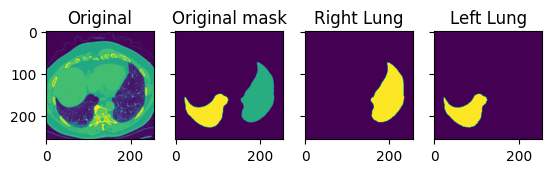

In [9]:
inspect_img=1
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.imshow(x_train[inspect_img])
ax2.imshow(y_train[inspect_img])
ax3.imshow(y_train_right[inspect_img])
ax4.imshow(y_train_left[inspect_img])
ax1.set_title('Original')
ax2.set_title('Original mask')
ax3.set_title('Right Lung')
ax4.set_title('Left Lung')
plt.show()

In [10]:
def multi_organ_loss(y_true, y_pred):
    loss_left = tf.keras.losses.binary_crossentropy(y_true[0], y_pred[0])
    loss_right = tf.keras.losses.binary_crossentropy(y_true[1], y_pred[1])

    # Combine the left and right lung loss (you can use any combination, e.g., sum, mean, etc.)
    combined_loss = loss_left + loss_right

    return combined_loss


In [11]:
# Example of using Dice loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)


In [12]:
# Define your model with the desired output shape
from tensorflow.keras.regularizers import l2

def get_multi_organ_unet(input_shape=(256, 256, 1), base=8, kernel_size=(3, 3), activation='relu', batchnorm=True, dropout=0.2):
    inputs = Input(input_shape)

    # Encoder (contracting path)
    # Block-1
    conv1 = conv_block(inputs, base=base, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    if dropout:
        pool1 = Dropout(dropout)(pool1)

    # Block-2
    conv2 = conv_block(pool1, base=base*2, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    if dropout:
        pool2 = Dropout(dropout)(pool2)

    # Block-3
    conv3 = conv_block(pool2, base=base*4, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    if dropout:
        pool3 = Dropout(dropout)(pool3)

    # Block-4
    conv4 = conv_block(pool3, base=base*8, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    if dropout:
        pool4 = Dropout(dropout)(pool4)

    # Block-5 Bottleneck
    conv5 = conv_block(pool4, base=base*16, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)

    # Decoder (expansion path)
    # Block-6
    up1 = Conv2DTranspose(base*8, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat1 = concatenate([up1, conv4], axis=3)
    if dropout:
        concat1 = Dropout(dropout)(concat1)
    conv6 = conv_block(concat1, base=base*8, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)

    # Block-7
    up2 = Conv2DTranspose(base*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat2 = concatenate([up2, conv3], axis=3)
    if dropout:
        concat2 = Dropout(dropout)(concat2)
    conv7 = conv_block(concat2, base=base*4, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)

    # Block-8
    up3 = Conv2DTranspose(base*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat3 = concatenate([up3, conv2], axis=3)
    if dropout:
        concat3 = Dropout(dropout)(concat3)
    conv8 = conv_block(concat3, base=base*2, kernel_size=kernel_size, activation=activation, batchnorm=batchnorm)

    # Block-9
    up4 = Conv2DTranspose(base, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat4 = concatenate([up4, conv1], axis=3)
    if dropout:
        concat4 = Dropout(dropout)(concat4)
        

    # Output layers for left and right lungs
    conv_left_lung = Conv2D(1, (1, 1), activation='sigmoid',kernel_regularizer=l2(1e-4))(concat4) #added l2 regulirization
    conv_right_lung = Conv2D(1, (1, 1), activation='sigmoid',kernel_regularizer=l2(1e-4))(concat4) #added l2 regulirization

    model = Model(inputs=inputs, outputs=[conv_left_lung, conv_right_lung])

    return model


In [13]:

# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=0.9
)

In [14]:
# Create and compile the model for multi-organ segmentation
model_multi_organ = get_multi_organ_unet(input_shape=(img_width, img_height, 1), base=base, batchnorm=batchnorm, dropout=dropout)
model_multi_organ.compile(optimizer=Adam(learning_rate=lr_schedule), loss=multi_organ_loss, metrics=[dice_coef, Precision(), Recall()])

In [15]:
# Train the model for multi-organ segmentation
history_multi_organ = model_multi_organ.fit(x_train, [y_train_left, y_train_right], batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(x_val, [y_val_left, y_val_right]))


Epoch 1/80
100/100 [==============================] - 11s 52ms/step - loss: 2.1187 - conv2d_16_loss: 1.4854 - conv2d_17_loss: 0.6329 - conv2d_16_dice_coef: 0.7048 - conv2d_16_precision_1: 1.0000 - conv2d_16_recall_1: 0.5255 - conv2d_17_dice_coef: 0.8388 - conv2d_17_precision_1: 1.0000 - conv2d_17_recall_1: 0.8743 - val_loss: 2.5911 - val_conv2d_16_loss: 1.2911 - val_conv2d_17_loss: 1.2996 - val_conv2d_16_dice_coef: 0.7118 - val_conv2d_16_precision_1: 1.0000 - val_conv2d_16_recall_1: 0.6267 - val_conv2d_17_dice_coef: 0.7055 - val_conv2d_17_precision_1: 1.0000 - val_conv2d_17_recall_1: 0.6526
Epoch 2/80
100/100 [==============================] - 4s 37ms/step - loss: 2.0338 - conv2d_16_loss: 1.4629 - conv2d_17_loss: 0.5705 - conv2d_16_dice_coef: 0.7081 - conv2d_16_precision_1: 1.0000 - conv2d_16_recall_1: 0.5254 - conv2d_17_dice_coef: 0.8492 - conv2d_17_precision_1: 1.0000 - conv2d_17_recall_1: 0.8792 - val_loss: 2.3774 - val_conv2d_16_loss: 1.2274 - val_conv2d_17_loss: 1.1496 - val_conv2

In [16]:

print(history_multi_organ.history.keys())


dict_keys(['loss', 'conv2d_16_loss', 'conv2d_17_loss', 'conv2d_16_dice_coef', 'conv2d_16_precision_1', 'conv2d_16_recall_1', 'conv2d_17_dice_coef', 'conv2d_17_precision_1', 'conv2d_17_recall_1', 'val_loss', 'val_conv2d_16_loss', 'val_conv2d_17_loss', 'val_conv2d_16_dice_coef', 'val_conv2d_16_precision_1', 'val_conv2d_16_recall_1', 'val_conv2d_17_dice_coef', 'val_conv2d_17_precision_1', 'val_conv2d_17_recall_1'])


In [17]:
# Define the keys to access the loss and metric values
loss = history_multi_organ.history['loss']
conv2d_16_loss = history_multi_organ.history['conv2d_16_loss']
conv2d_17_loss = history_multi_organ.history['conv2d_17_loss']
conv2d_16_dice_coef = history_multi_organ.history['conv2d_16_dice_coef']
conv2d_16_precision = history_multi_organ.history['conv2d_16_precision_1']
conv2d_16_recall = history_multi_organ.history['conv2d_16_recall_1']
conv2d_17_dice_coef = history_multi_organ.history['conv2d_17_dice_coef']
conv2d_17_precision = history_multi_organ.history['conv2d_17_precision_1']
conv2d_17_recall = history_multi_organ.history['conv2d_17_recall_1']


In [18]:
# Evaluate the model's performance using Dice, Precision, and Recall metrics
results = model_multi_organ.evaluate(x_val, [y_val_left, y_val_right], verbose=0)
print("Multi-Organ Segmentation Metrics on Validation Set:")
print("Dice (Left Lung):", results[1])
print("Dice (Right Lung):", results[2])
print("Precision (Left Lung):", results[3])
print("Precision (Right Lung):", results[4])
print("Recall (Left Lung):", results[5])
print("Recall (Right Lung):", results[6])

Multi-Organ Segmentation Metrics on Validation Set:
Dice (Left Lung): 0.729175865650177
Dice (Right Lung): -0.46548697352409363
Precision (Left Lung): 0.8184133768081665
Precision (Right Lung): 1.0
Recall (Left Lung): 0.8140571713447571
Recall (Right Lung): 0.9579192399978638


7/7 [==============================] - 0s 24ms/step


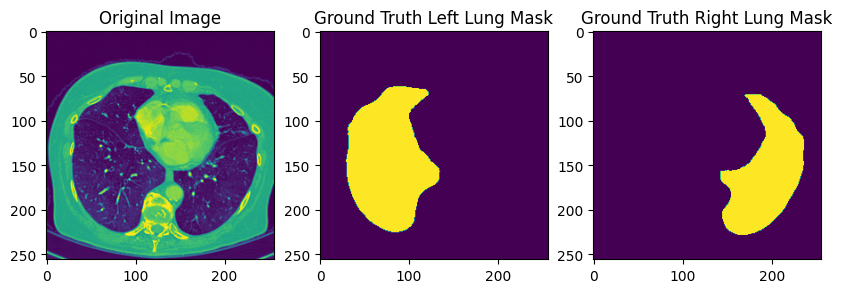

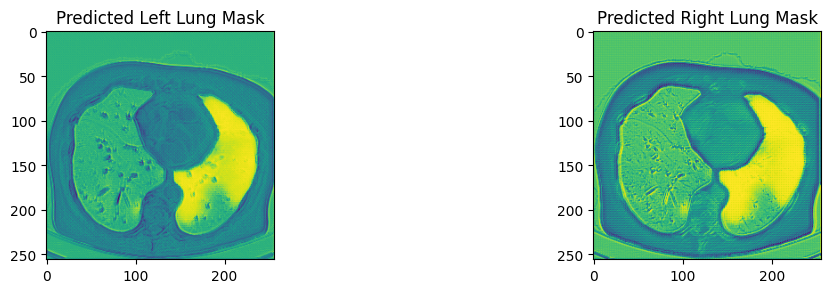

In [21]:
# Make predictions on the validation set (you can replace x_val with your new images)
predictions = model_multi_organ.predict(x_val)
import matplotlib.pyplot as plt

# Choose an index for the image you want to visualize
image_index = 1  # Change this to the index of the image you want to visualize

# Retrieve the predicted masks for left and right lungs
predicted_left_lung_mask = predictions[0][image_index]
predicted_right_lung_mask = predictions[1][image_index]

# Retrieve the corresponding ground truth masks (if available)
ground_truth_left_lung_mask = y_val_left[image_index]
ground_truth_right_lung_mask = y_val_right[image_index]

# Retrieve the original image for context (if available)
original_image = x_val[image_index]

# Plot the original image
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image)

# Plot the ground truth masks (if available)
plt.subplot(132)
plt.title("Ground Truth Left Lung Mask")
plt.imshow(ground_truth_left_lung_mask)

plt.subplot(133)
plt.title("Ground Truth Right Lung Mask")
plt.imshow(ground_truth_right_lung_mask)

# Plot the predicted masks
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.title("Predicted Left Lung Mask")
plt.imshow(predicted_left_lung_mask)

plt.subplot(133)
plt.title("Predicted Right Lung Mask")
plt.imshow(predicted_right_lung_mask)

plt.show()
